In [124]:
import pandas as pd
import re
import numpy as np
from time import time 
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from wordcloud import WordCloud
from umap import UMAP
from mpl_toolkits.mplot3d import Axes3D
import multiprocessing
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from spacy.lang.es.stop_words import STOP_WORDS
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from spacy.lang.es import Spanish
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import es_core_news_sm
import networkx as nx
import chart_studio.plotly as py
import spacy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/miniconda3/envs/py366/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['datetime', 'time', 'seed']
`%matplotlib` prevents importing * from pylab and numpy



In [125]:
tweets_user = pd.read_csv('/Users/Noelia/Desktop/DATA_IRONHACK/FINAL_PROJECT/final_project_ironhack/output/User_csv/@virginiagruul_tweets.csv')

In [126]:
tweets_user.head()

,id,created_at,text
0,1158505900438687745,2019-08-05 22:31:45,"En siete meses, ¿qué has hecho?\n(Version 🔞)\n..."
1,1158335287375880192,2019-08-05 11:13:47,@_leatherbitch 💅🏻
2,1158009651910365185,2019-08-04 13:39:50,JAMÁS habrá justificación para ponerlos. https...
3,1157607431607914497,2019-08-03 11:01:33,RT @ReggaetonAPA: Nadie:\n\nAbsolutamente nadi...
4,1157296692494032896,2019-08-02 14:26:47,Siempre se me pierden https://t.co/DVEzhsXxkk


In [127]:
def retweet(input_text):
    if input_text.startswith("RT"):
        value = 1
    else:
        value = 0
    return value

In [128]:
tweets_user['RT'] = tweets_user.text.apply(retweet)

In [129]:
tweets_user['mention'] = tweets_user.text.str.findall(r'(?<![@\w])@(\w{1,25})').apply(', '.join)

In [130]:
tweets_user['hashtag'] = tweets_user.text.str.extract(r'(\#\w+)', expand=False)

In [131]:
tweets_user['hashtag'] = tweets_user['hashtag'].fillna("")

In [132]:
tweets_user['date'] = tweets_user['created_at']

In [133]:
tweets_user['date'] = pd.DatetimeIndex(tweets_user['created_at']).to_period('D')

In [134]:
tweets_user = tweets_user.drop(columns=["created_at"], axis=1)

In [135]:
nlp = es_core_news_sm.load()

In [136]:
nlp = spacy.load('es', parser=True)

In [137]:
nlp.Defaults.stop_words |= {"RT","próx", "xd", "rt", "htt", "parir", "sobrar"}

In [138]:
def spacy_tokenizer(sentence):
    sentence = re.sub(r'htt\S+', '', sentence)
    tokens = nlp(sentence)
    filtered_tokens = []
    for word in tokens:
        lemma = word.lemma_.lower().strip()
        
        if lemma not in STOP_WORDS and re.search('^[a-zA-ZñÑáéíóúÁÉÍÓÚ]{2}\w+', lemma):
            filtered_tokens.append(lemma)

    return filtered_tokens

In [139]:
tweets_user['tokenized'] = tweets_user['text'].apply(spacy_tokenizer)

In [140]:
tweets_user['tokenized'][1565]

['volver', 'crazys', 'tía', 'ains', 'ganazas']

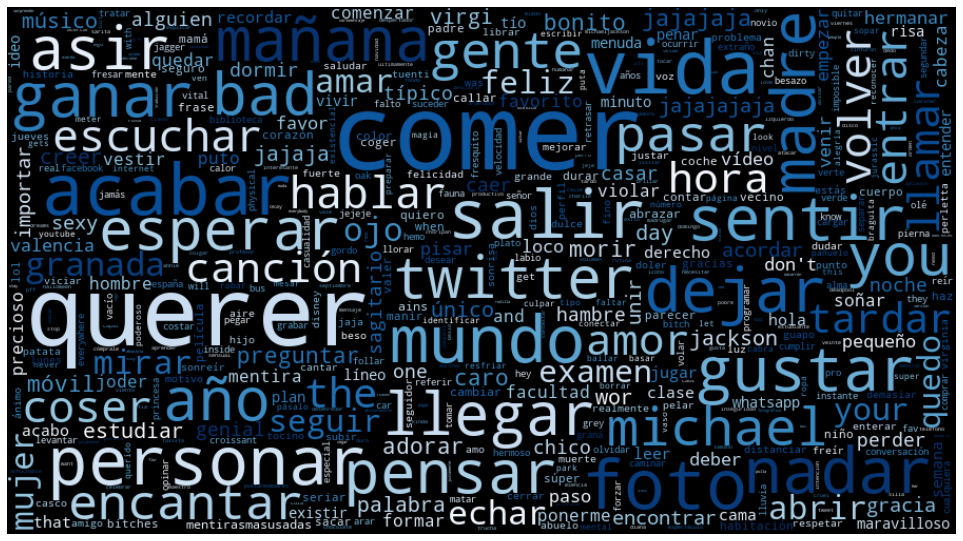

In [142]:
num_features = 300
min_word_count = 50
num_workers = multiprocessing.cpu_count()
context_size = 10
downsampling = 1e-4
seed = 2

all_words = []
for line in tweets_user['tokenized']: 
    all_words.extend(line)
    
wordfreq = Counter(all_words)
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [68]:
tfidf_vectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer, min_df=3)

%time tfidf_matrix_friends = tfidf_vectorizer.transform(tweets_user_friends['text'].values)

print(tfidf_matrix.shape)

CPU times: user 13.1 s, sys: 48.4 ms, total: 13.2 s
Wall time: 13.2 s
(1569, 441)


In [69]:
terms = tfidf_vectorizer.get_feature_names()

In [70]:
array_matrix = tfidf_matrix.toarray()

In [71]:
first_vector_tfidfvectorizer=tfidf_matrix[0]
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False).head()

,tfidf
mesar,1.0
abrazar,0.0
pañuelo,0.0
perro,0.0
perletta,0.0


In [72]:
vocab = tfidf_vectorizer.vocabulary_

In [73]:
dist = 1 - cosine_similarity(tfidf_matrix)
dist

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [74]:
umap = UMAP(n_components=2, n_neighbors=5, random_state=42)
embedding = umap.fit_transform(tfidf_matrix)

/miniconda3/envs/py366/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 27 separate connected components using meta-embedding (experimental)



In [75]:
umap_df = pd.DataFrame(embedding, columns=[f'emb_{i+1}' for i in range(2)])

In [76]:
umap_df.head()

,emb_1,emb_2
0,-5.642003,-4.727313
1,-5.455755,-5.841423
2,-6.791360,-4.519105
3,10.744144,0.532054
4,10.649951,0.578694


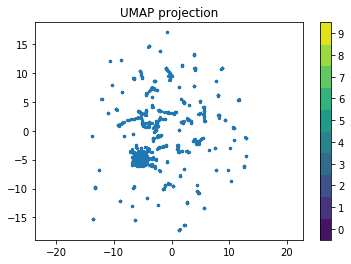

In [77]:
plt.scatter(umap_df['emb_1'], umap_df['emb_2'], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection', fontsize=12);

In [82]:
tweets = {'tweet': tweets_user['text'].values, "words": tweets_user['tokenized'].values, 'cluster': clusters, "mention": tweets_user['mention'].values, "RT": tweets_user['RT'].values, "date": tweets_user['date'].values}
cluster_friend = pd.DataFrame(tweets, columns = ['tweet', 'words', "cluster", "mention", "RT", "date"])

In [84]:
cluster_friend[cluster_friend['cluster']==4].head()

,tweet,words,cluster,mention,RT,date
8,RT @grupodelwhatsap: Hay un\nP a r i\nDespués ...,[llamar],4,grupodelwhatsap,1,2019-07-22
13,RT @uvemay: Soy el único al que si pegas un pu...,"[único, pegar, puñetazo, tráquea, disparo, rod...",4,uvemay,1,2019-07-01
18,RT @ReggaetonAPA: . \n ...,[],4,ReggaetonAPA,1,2019-06-23
22,RT @MyNameIsSergio9: POR FAVOR DAME TU RT\n\n7...,"[favor, dame, soldar, imperial, graduación, he...",4,MyNameIsSergio9,1,2019-06-10
66,RT @yisucrist: x favor mirad como mueve las pa...,"[favor, mirar, comer, mover, patitas, morir]",4,yisucrist,1,2018-12-06


In [85]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)
tfidf_df.head()

,abrazar,abrazo,abrir,abuelo,acabar,acercar,achuchable,acordar,adorar,ains,...,when,will,with,you,your,youtube,ánimo,éxito,últimamente,único
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
def get_df_from_cluster(cluster):
    return tfidf_df[clustering==cluster]

In [145]:
top_words_cluster = get_df_from_cluster(4).T.sum(axis=1).sort_values(ascending=False)
top_words_cluster.head()

morir       9.002708
venir       7.282064
pasar       5.574662
sexy        5.401960
whatsapp    4.341747
dtype: float64

In [88]:
umap = UMAP(n_components=3, n_neighbors=3)
embedding = umap.fit_transform(dist)

/miniconda3/envs/py366/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 27 separate connected components using meta-embedding (experimental)



In [89]:
umap_df = pd.DataFrame(embedding, columns=[f'emb_{i+1}' for i in range(3)])

umap_df.head()

,emb_1,emb_2,emb_3
0,0.440009,5.902447,6.849111
1,0.487678,6.021548,6.909897
2,1.110913,6.471354,6.802863
3,1.931121,-8.549730,3.589386
4,2.110162,-8.643667,3.389956


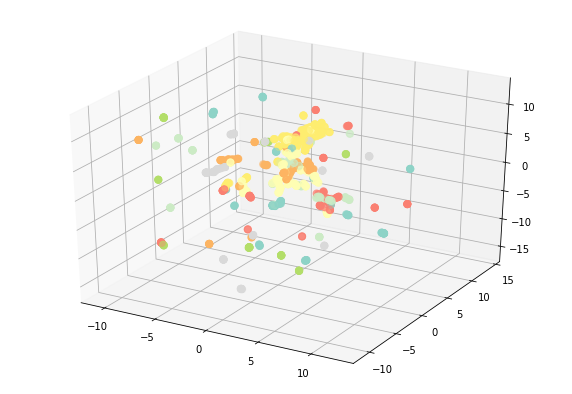

In [90]:
plt.figure('K-Means Cluster', figsize=(10,7))
ax = plt.axes(projection = '3d')
ax.scatter(umap_df['emb_1'],umap_df['emb_2'],umap_df['emb_3'], c=km.labels_ , cmap='Set3', s=50)

In [91]:
import plotly.express as px
#iris = px.data.iris()
fig = px.scatter_3d(umap_df, x='emb_1', y='emb_2', z='emb_3',
              color='emb_3', size_max=20,
            opacity=0.7)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [92]:
cluster_friend.mention.value_counts()

                                    696
HelenaBadDanger                      70
MarisolCara                          37
HelenaBadDanger, VirgiBadJackson     32
Carol_XtarGirl                       29
                                   ... 
FranArcoG, VirgiSayMyName             1
MedievoReaction                       1
bitchpeach_                           1
LigoteoUGR                            1
JodidaAdiccion_                       1
Name: mention, Length: 310, dtype: int64

In [97]:
cluster_friend = cluster_friend[cluster_friend['mention']!=""]

In [120]:
cluster_friend = cluster_friend[cluster_friend['words']!="[]"]
cluster_friend.reset_index(drop=True)

,tweet,words,cluster,mention,RT,date
0,RT @ReggaetonAPA: Nadie:\n\nAbsolutamente nadi...,"[absolutamente, bad, bunny]",2,ReggaetonAPA,1,2019-08-03
1,RT @grupodelwhatsap: Hay un\nP a r i\nDespués ...,[llamar],4,grupodelwhatsap,1,2019-07-22
2,RT @HelenaLoveno: Vaya mierda de día(s),"[mierda, día(s]",7,HelenaLoveno,1,2019-07-16
3,RT @itsdaneesaur: Can everybody just Please lo...,"[can, everybody, just, please, look, this, cat]",7,itsdaneesaur,1,2019-07-04
4,RT @uvemay: Soy el único al que si pegas un pu...,"[único, pegar, puñetazo, tráquea, disparo, rod...",4,uvemay,1,2019-07-01
5,"RT @__laugs: Yo con 12 años después de decir ""...","[año, preguntar]",6,__laugs,1,2019-06-27
6,RT @sobadisimo: dracukeo \nel reciclador\nlos ...,"[dracukeo, reciclador, residuo, contenedor]",7,sobadisimo,1,2019-06-26
7,RT @drewflocka2: Her: “he’s probably out cheat...,"[her, probably, out, cheating, with, the, boys]",2,drewflocka2,1,2019-06-23
8,RT @Animeiberico: Veo a mucha gente quejándose...,"[veo, gente, quejándose, traducción, evangelio...",1,Animeiberico,1,2019-06-23
9,@ScytheClaire Yamato 🍱,[yamato],7,ScytheClaire,0,2019-06-15


In [121]:
cluster_friend['mention'].value_counts()

HelenaBadDanger                     68
MarisolCara                         34
HelenaBadDanger, VirgiBadJackson    31
MarisolCara, VirgiBadJackson        26
Carol_XtarGirl                      25
                                    ..
LigoteosUGR                          1
agarzon                              1
Paisajes_Es                          1
ImaBieberQueen                       1
MjStyleMadrid                        1
Name: mention, Length: 291, dtype: int64

In [122]:
cluster_friend = cluster_friend[cluster_friend.astype(str)['words'] != '[]']

In [123]:
cluster_friend.to_csv("../output/cluster_friend.csv")